# Project Title: Detection of cancer in breast ultrasound images 
Team: Sruthi Machina and Kishan B Shah

Link to the dataset: <https://www.kaggle.com/datasets/aryashah2k/breast-ultrasound-images-dataset>

## Image analysis of Breast Ultra Sound Image dataset

### Import packages

In [3]:
import os
import re
import random
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import skimage.feature
from skimage import exposure, data, img_as_float
from skimage.color import rgb2gray
from skimage.filters import prewitt_h,prewitt_v

from utils import init_img_dict, get_file_dicts, filter_files, find_mask, print_ndarray_info
from utils import img_read, img_write, img_resize, img_flip, comp_fft, histogram_equalization
from utils import display_img, display_img_list_3, display_3_imgs, display_3_hist, resize_imgs, flip_imgs, append_img_data

## Data structure to hold image information
We use a dictionary object to keep information for each image in the dataset. The datasets for the 3 classes are represented by 3 separate lists,  which contain a dictionary object for each file in the dataset. There are `133` images in normal image dataset, `437` in benign and `210` in malignant image dataset. For now, the dictionary object is initialized as
```
dict_object = {'file_name_fullpath': None, 'file_name': None, 
               'file_stem': None, 'file_suffix': None, 
               'file_masks': None}
```
Where `file_name_fullpath` is the image file name with full path, `file_name` is image file name without the path, `file_stem` is file name without the extension, `file_suffix` is the file extension and `file_masks` is a list containing masks (with full path) correponding to the image.

We will add more properties corresponding to images in the dictionary object, as needed. 

Example: In the directory containing images for benign cases, `./Dataset_BUSI_with_GT/benign`, there is an image file `benign (1).png`. The dictionary object (on Windows) is:
```
benign_img_list[0] = {
            'file_name_fullpath': './Dataset_BUSI_with_GT/benign\\benign (1).png', 
            'file_name': 'benign (1).png', 
            'file_stem': 'benign (1)', 
            'file_suffix': '.png', 
            'file_masks': ['./Dataset_BUSI_with_GT/benign\\benign (1)_mask.png']
}
```

Note: Since benign dataset contains `437` images, the `benign_img_list` has `437` dictionary objects.

Note: there can be more that one mask per image. So the `file_mask` is a list of masks (which usually has just one element) for each image.

The code below builds the data structure for each image and extracts corresponding masks. It creates 3 image lists : `normal_img_list`, `benign_img_list`, and `malignant_img_list` for normal, benign, and malignant classes, respectively.

### Helper functions to build the data structure and extract masks corresponding to each image

### Create image list (with dict object for each image) for the 3 classes

In [5]:
normal_img_dir = './Dataset_BUSI_with_GT/normal'
benign_img_dir = './Dataset_BUSI_with_GT/benign'
malignant_img_dir = './Dataset_BUSI_with_GT/malignant'

# Get a list of images in the images directory
normal_img_list = get_file_dicts(normal_img_dir)
num_normal_img = len(normal_img_list)
print(f"Number of images in normal dataset: {num_normal_img}")
#print(normal_img_list[11])

benign_img_list = get_file_dicts(benign_img_dir)
num_benign_img = len(benign_img_list)
print(f"Number of images in benign dataset: {num_benign_img}")
#print(benign_img_list[0])

malignant_img_list = get_file_dicts(malignant_img_dir)
num_malignant_img = len(malignant_img_list)
print(f"Number of images in malignant dataset: {num_malignant_img}")
#print(malignant_img_list[33])

num_total_img = num_normal_img + num_benign_img + num_malignant_img
num_positive = num_malignant_img
num_negative = num_normal_img + num_benign_img

print(f"Total number of images in the dataset: {num_total_img} \n")
print(f"% of normal images in the dataset: {100*num_normal_img/num_total_img:0.2f}% ")
print(f"% of benign images in the dataset: {100*num_benign_img/num_total_img:0.2f}% ")
print(f"% of malignant images in the dataset: {100*num_malignant_img/num_total_img:0.2f}% ")

print(f"% of positive images (malignant) in the dataset: {100*num_positive/num_total_img:0.2f}% ")
print(f"% of negative images (normal + benign) in the dataset: {100*num_negative/num_total_img:0.2f}% ")

# Some images have more than one mask but are there any images without mask?

Number of images in normal dataset 133
Number of images in benign dataset 437
Number of images in malignant dataset 210
Total number of images in the dataset 780 

% of normal images in the dataset 17.05% 
% of benign images in the dataset 56.03% 
% of malignant images in the dataset 26.92% 
% of positive images (malignant) in the dataset 26.92% 
% of negative images (normal + benign) in the dataset 73.08% 


## Image analysis of the 3 datasets
First, we perform visual reviews of images in the dataset. We will display 3 random images and their mask from the normal, benign, and malignant classes. 

In order to avoid bias due to index order, we shuffle the image list for each class then select 3 random samples from each to show.

In [6]:
# Shuffle the images lists to avoid bias from indexing
random.seed(10)

random.shuffle(normal_img_list)
random.shuffle(benign_img_list)
random.shuffle(malignant_img_list)

# Now, select 3 random elements from each list to show
normal_img_list_3 = random.sample(normal_img_list, 3)
benign_img_list_3 = random.sample(benign_img_list, 3)
malignant_img_list_3 = random.sample(malignant_img_list, 3)

### Visual analysis with mask, histogram and frequency
Let's review the images. We review 3 images from each data set. For each of 3 images from the data set, let's looks at
 - image with mask to observe if masks for the 3 classes have any distinguishing features
 - image with historgram to observe if the 3 classes have any distinguishing features in their histogram
 - image with Fourier signal to observe if the 3 classes have any distinguishing features in Fourier space

### Show 3 random images from each class along with their masks

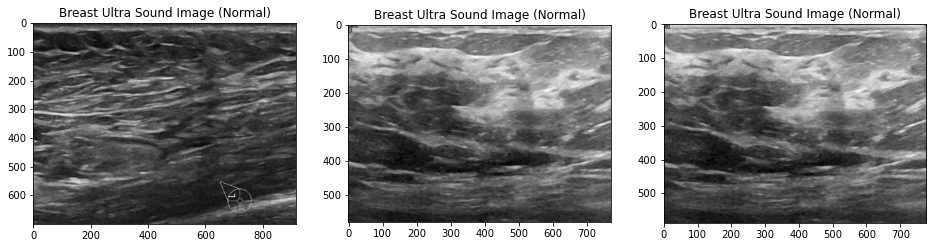

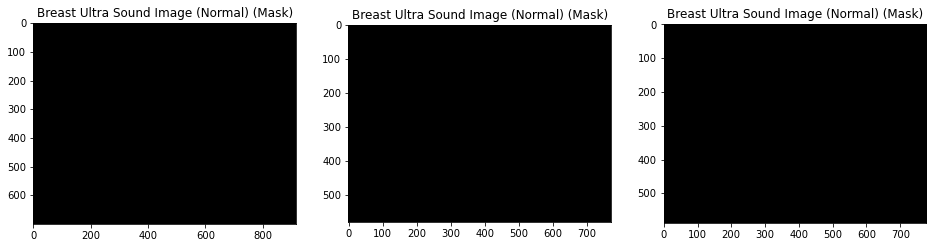

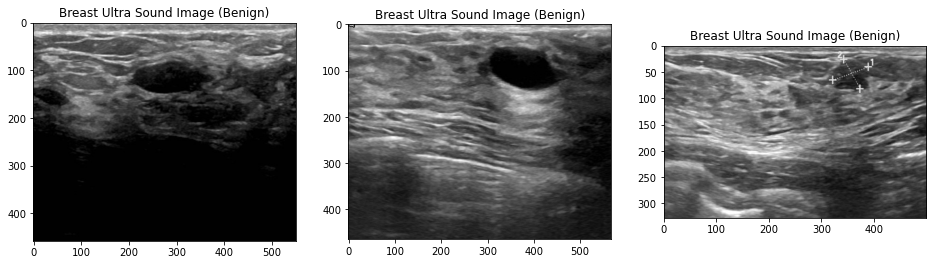

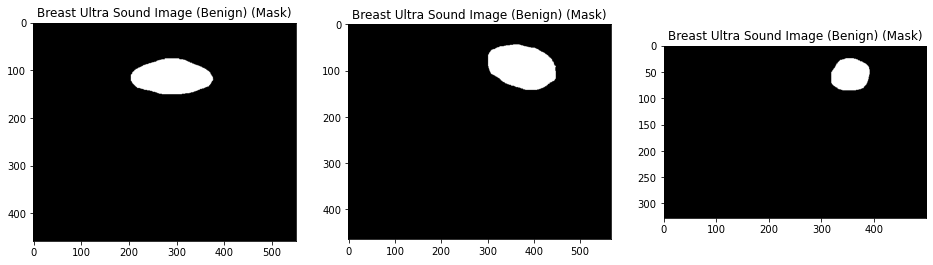

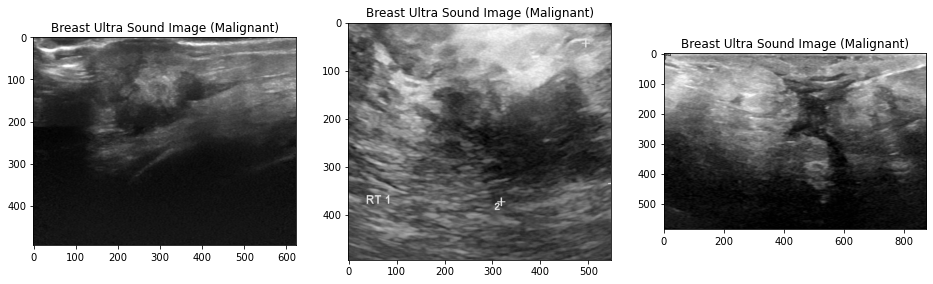

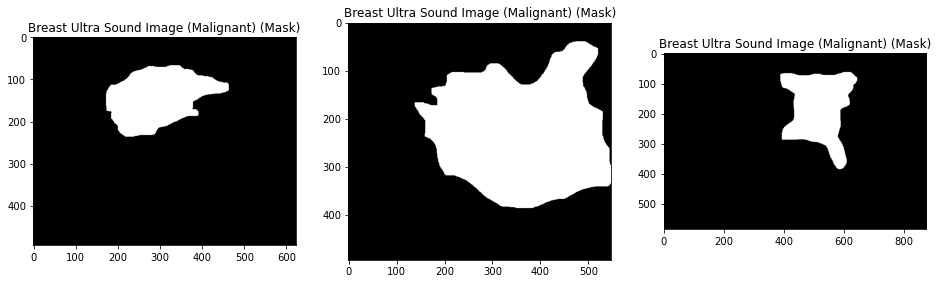

In [7]:
img_title = 'Breast Ultra Sound Image (Normal)'
display_img_list_3(normal_img_list_3, img_title, with_mask= True)

img_title = 'Breast Ultra Sound Image (Benign)'
display_img_list_3(benign_img_list_3, img_title, with_mask= True)

img_title = 'Breast Ultra Sound Image (Malignant)'
display_img_list_3(malignant_img_list_3, img_title, with_mask= True)

### Show histogram of the 3 random images in each class

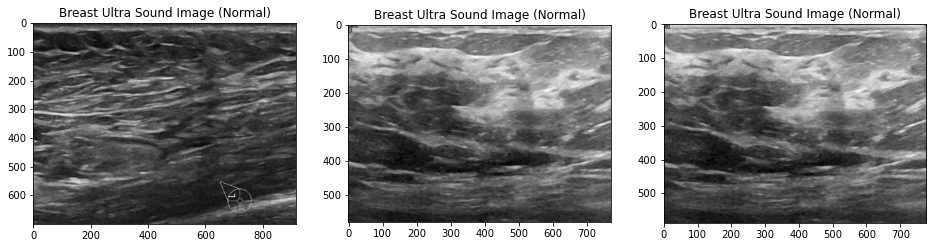

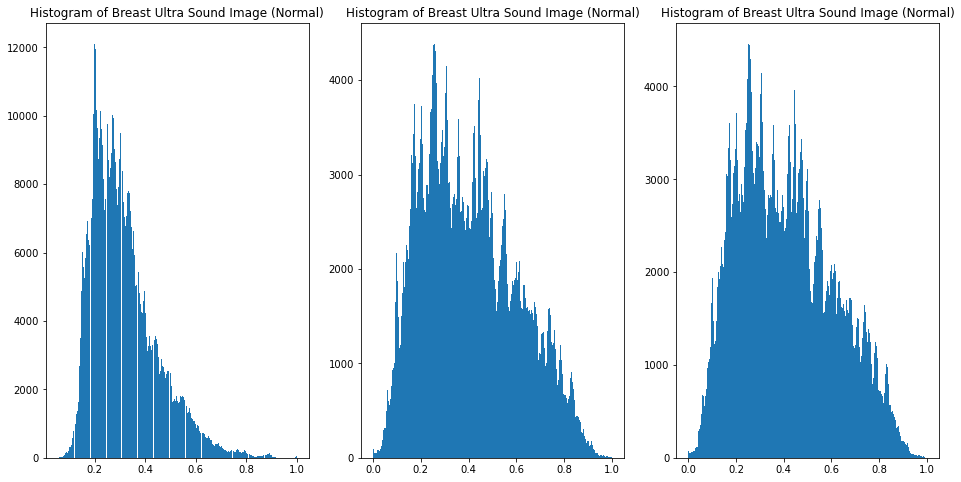

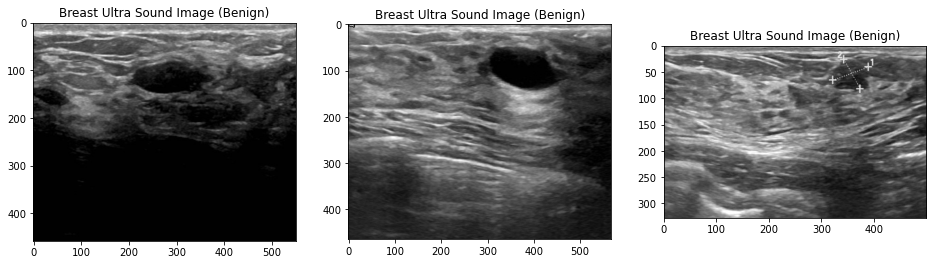

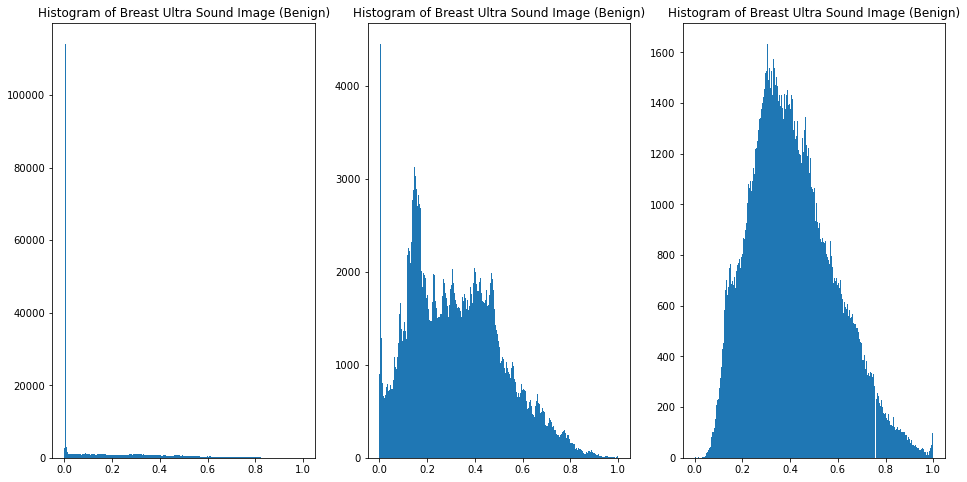

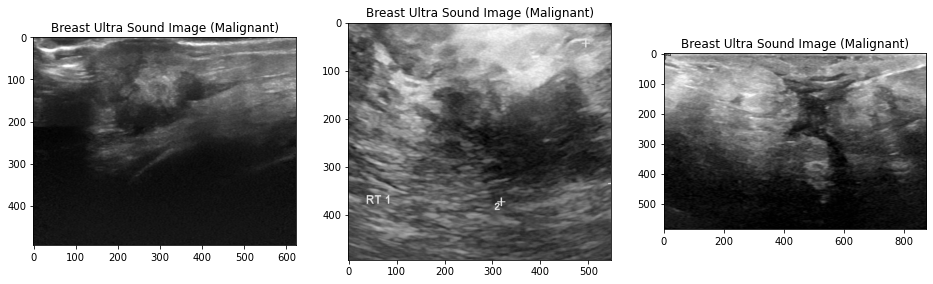

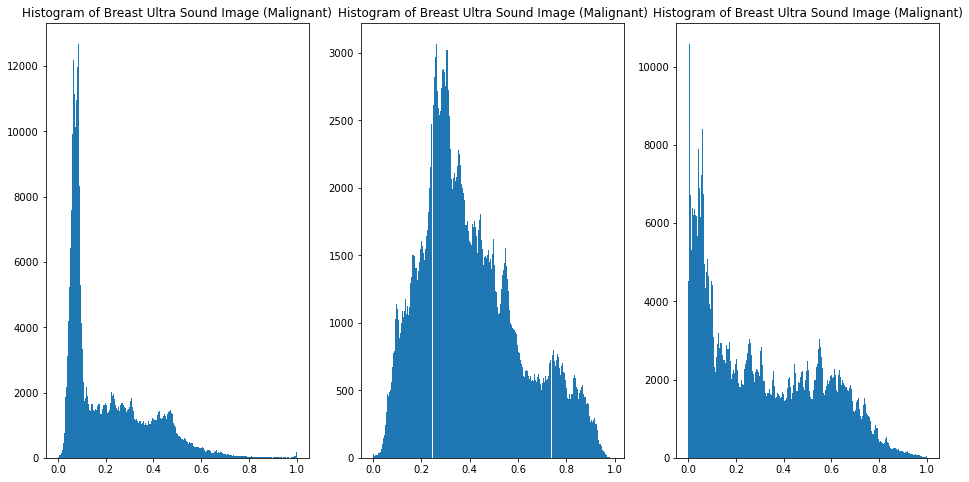

In [8]:
# display historgram of 3 random images from the list
img_title = 'Breast Ultra Sound Image (Normal)'
display_img_list_3(normal_img_list_3, img_title, with_hist= True)

img_title = 'Breast Ultra Sound Image (Benign)'
display_img_list_3(benign_img_list_3, img_title, with_hist= True)

img_title = 'Breast Ultra Sound Image (Malignant)'
display_img_list_3(malignant_img_list_3, img_title, with_hist= True)

### Show frequency content of the 3 random images in each class 
Use FFT to compute magnitude of Fourier coefficients and display

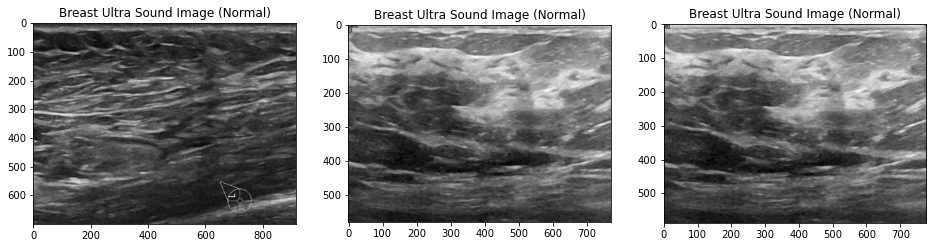

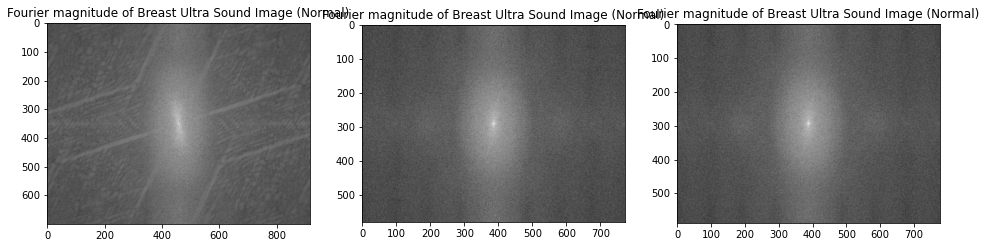

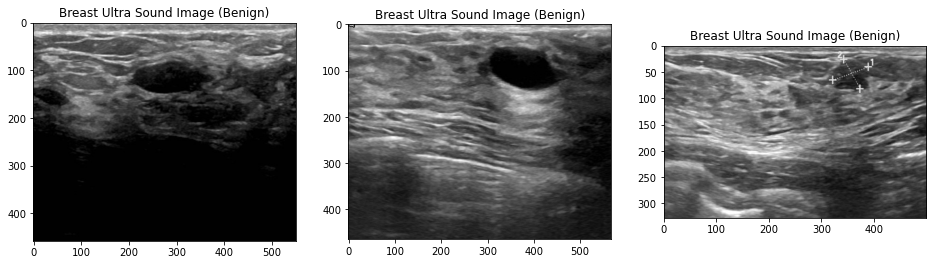

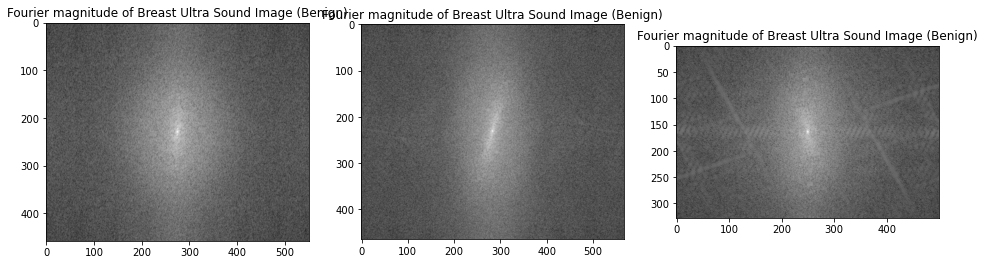

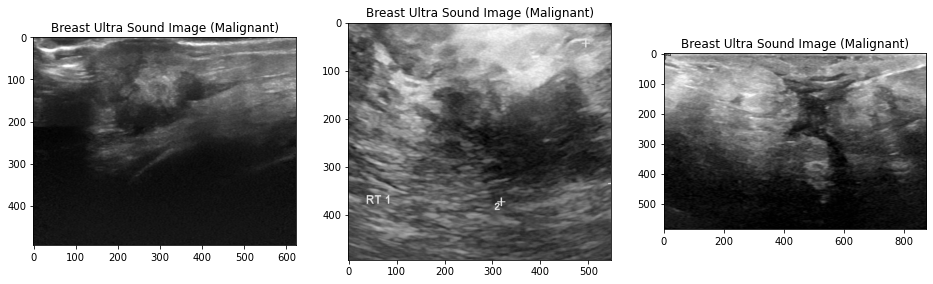

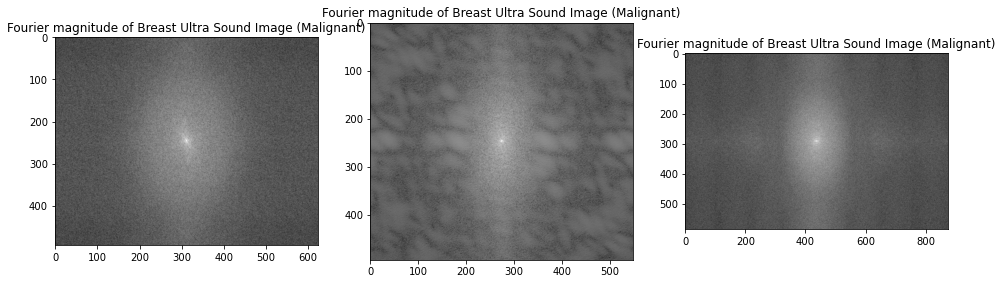

In [9]:
# display Fourier magnitude of 3 random images from the list
img_title = 'Breast Ultra Sound Image (Normal)'
display_img_list_3(normal_img_list_3, img_title, with_fft= True, log= True)

img_title = 'Breast Ultra Sound Image (Benign)'
display_img_list_3(benign_img_list_3, img_title, with_fft= True, log= True)

img_title = 'Breast Ultra Sound Image (Malignant)'
display_img_list_3(malignant_img_list_3, img_title, with_fft= True, log= True)

### Feature Analysis
 0. Prefilter (Historgram equalization)
 1. edge feature extraction (Prewitt, Sobel, Canny)
 2. Corner detection (Harris and Shi-Tomasi)
 2. Feature descriptors (SIFT, SURF, HOG)

#### Edge detection

Benign image 1 [ndim, shape, dtype, min, max] : [2, (465, 567), float32, 0.0, 1.0]


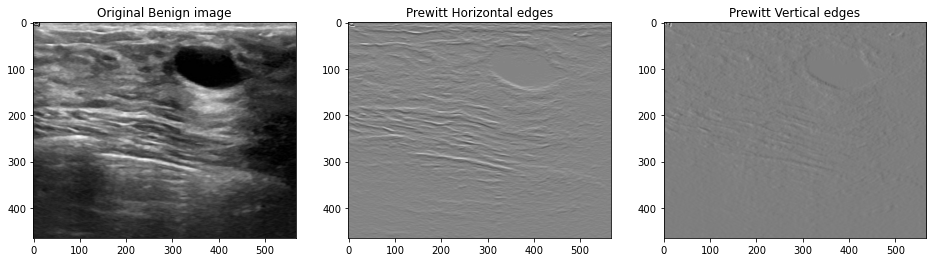

In [10]:
# Prewitt Edge feature extraction

img_file = benign_img_list_3[1]['file_name_fullpath']
img = img_read(img_file, toFloat = True)
print_ndarray_info(img, "Benign image 1")

# Extract horizontal and vertical edges using prewitt kernel
edges_prewitt_horizontal = prewitt_h(img)
edges_prewitt_vertical = prewitt_v(img)

img_title_list = ["Original Benign image", "Prewitt Horizontal edges",  "Prewitt Vertical edges"]
display_3_imgs([img, edges_prewitt_horizontal, edges_prewitt_vertical], img_title_list)

Original Benign image 1 [ndim, shape, dtype, min, max] : [2, (465, 567), float32, 0.0, 1.0]
Blur Benign image 1 [ndim, shape, dtype, min, max] : [2, (465, 567), float32, 0.0004901961074210703, 0.9955881834030151]


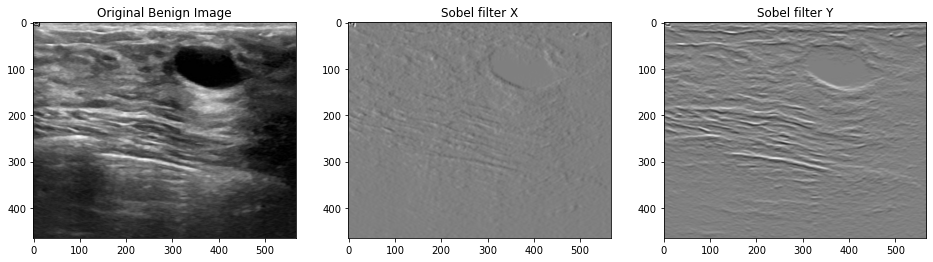

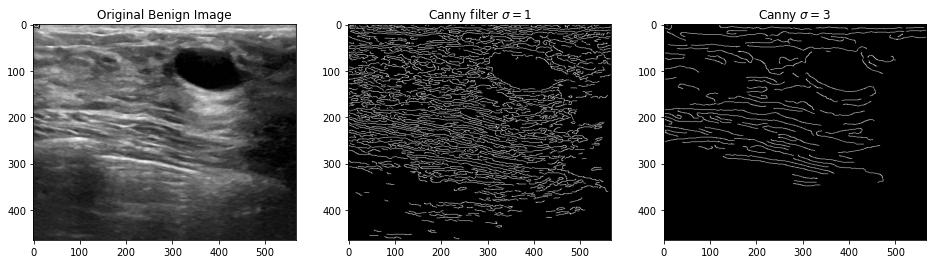

In [11]:
# Sobel and canny filter

# Read a sample image
img_file = benign_img_list_3[1]['file_name_fullpath']
mask_file = benign_img_list_3[1]['file_masks'][0]
img = img_read(img_file, toFloat = True)
img_mask = img_read(mask_file, toFloat = True)

print_ndarray_info(img, "Original Benign image 1")

# Blur the image for better edge detection
img_blur = cv2.GaussianBlur(img, (3,3), 0) 
print_ndarray_info(img_blur, "Blur Benign image 1")

# Sobel Edge Detection (what is dx and dy) 
# Need to understand what the ddepth is. seems like indicate output destination depth
# Makes much difference using  vs cv2.CV_8Ucv2.CV_32F
sobelx = cv2.Sobel(src= img_blur, ddepth= cv2.CV_32F, dx= 1, dy= 0, ksize= 5) # Sobel Edge Detection on the X axis
sobely = cv2.Sobel(src= img_blur, ddepth= cv2.CV_32F, dx= 0, dy= 1, ksize= 5) # Sobel Edge Detection on the Y axis
#sobelxy = cv2.Sobel(src=img_blur, ddepth= cv2.CV_32F, dx=1, dy=1, ksize=5) # Combined X and Y Sobel Edge Detection

display_3_imgs([img, sobelx, sobely], ["Original Benign Image", "Sobel filter X", "Sobel filter Y"])

# CV2 Canny edge detection (works only on UINT 8 data type) but skimage OK on float gray
#canny_edges_1 = cv2.Canny(image= img_blur_unit8, threshold1= 100, threshold2= 255) 
#canny_edges_2 = cv2.Canny(image= img_blur_unit8, threshold1= 100, threshold2= 150)
canny_edges_1 = skimage.feature.canny(img, sigma= 1)
canny_edges_2 = skimage.feature.canny(img, sigma= 3)
display_3_imgs([img, canny_edges_1, canny_edges_2], ["Original Benign Image", "Canny filter $\sigma = 1$", "Canny $\sigma = 3$"])

#### Corner features (Harris and Shi-Tomasi)

Original Malignant image 1 [ndim, shape, dtype, min, max] : [2, (494, 623), float32, 0.0, 1.0]
Blur Malignant image 1 [ndim, shape, dtype, min, max] : [2, (494, 623), float32, 0.002696078736335039, 0.9997549057006836]


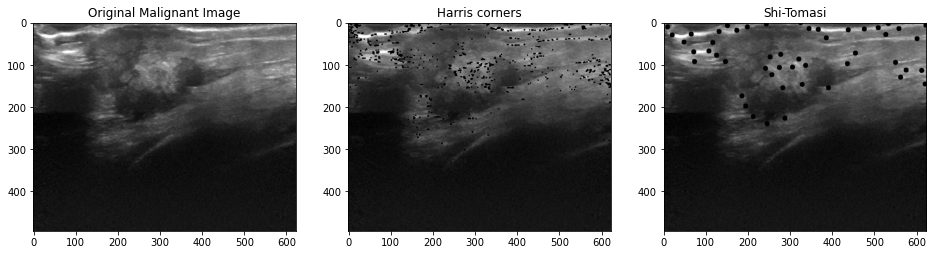

In [12]:
# Read a sample image
img_file = malignant_img_list_3[0]['file_name_fullpath']
mask_file = malignant_img_list_3[0]['file_masks'][0]
img = img_read(img_file, toFloat = True)
img_mask = img_read(mask_file, toFloat = True)

print_ndarray_info(img, "Original Malignant image 1")

# Blur the image for better edge detection
img_blur = cv2.GaussianBlur(img, (3,3), 0) 
print_ndarray_info(img_blur, "Blur Malignant image 1")

# Haris corner detection
dst = cv2.cornerHarris(img, blockSize=2, ksize=3, k=0.04)
  
# dilate to mark the corners
dst = cv2.dilate(dst, None)
img_cp = img.copy()
img_cp[dst > 0.01 * dst.max()] = 0

# Shi-Tomasi corner detection
corners = cv2.goodFeaturesToTrack(img, maxCorners=50, qualityLevel=0.02, minDistance=20)
corners = np.float32(corners)

img_cp2 = img.copy() 
for item in corners:
    x, y = item[0]
    x = int(x)
    y = int(y)
    cv2.circle(img_cp2, (x, y), 6, (0, 255, 0), -1)

display_3_imgs([img, img_cp, img_cp2], ["Original Malignant Image", "Harris corners", "Shi-Tomasi"])

#### Feature descriptors
 1. SIFT
 3. ORB (Oriented FAST and Rotated Brief)

Original Benign image 1 [ndim, shape, dtype, min, max] : [2, (465, 567), uint8, 0, 255]
Blur Benign image 1 [ndim, shape, dtype, min, max] : [2, (465, 567), uint8, 0, 254]


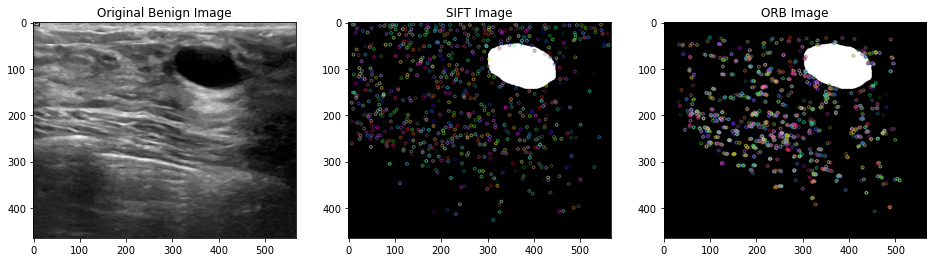

In [13]:
# Read a sample image
img_file = benign_img_list_3[1]['file_name_fullpath']
mask_file = benign_img_list_3[1]['file_masks'][0]
img = img_read(img_file, toFloat = False)
img_float = img_read(img_file, toFloat = True)
img_mask = img_read(mask_file, toFloat = False)

print_ndarray_info(img, "Original Benign image 1")

# Blur the image for better edge detection
img_blur = cv2.GaussianBlur(img, (3,3), 0) 
print_ndarray_info(img_blur, "Blur Benign image 1")

# Create SIFT feature extractor
sift = cv2.SIFT_create()

# detect features (keypoints and descriptors) from the image
keypoints, descriptors = sift.detectAndCompute(img, None)

# Draw the detected key points
# flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
# flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS
sift_image = cv2.drawKeypoints(img_mask, keypoints, 0, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

# ORB
orb = cv2.ORB_create(nfeatures=2000)
keypoints, descriptors = orb.detectAndCompute(img, None)
  
# Drawing the keypoints
#orb_image = cv2.drawKeypoints(img_mask, keypoints, None, color=(0, 255, 0), flags=0)
orb_image = cv2.drawKeypoints(img_mask, keypoints, 0, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

display_3_imgs([img, sift_image, orb_image], ["Original Benign Image", "SIFT Image", "ORB Image"])